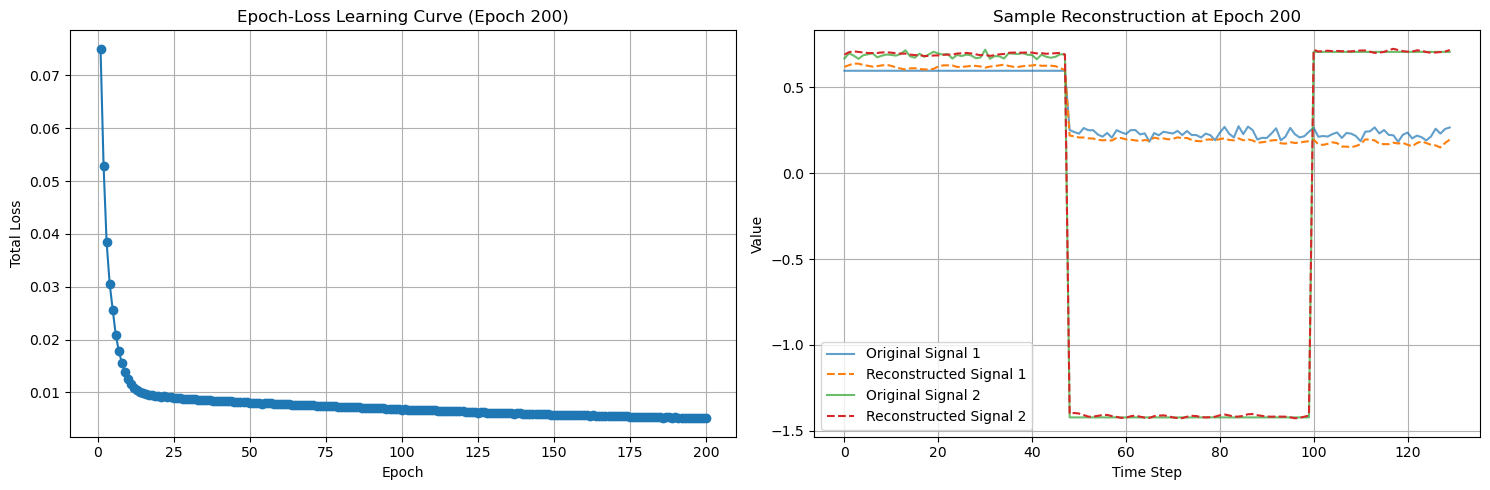

Training finished.

Predicting on normal test data...
Predicting on abnormal test data...


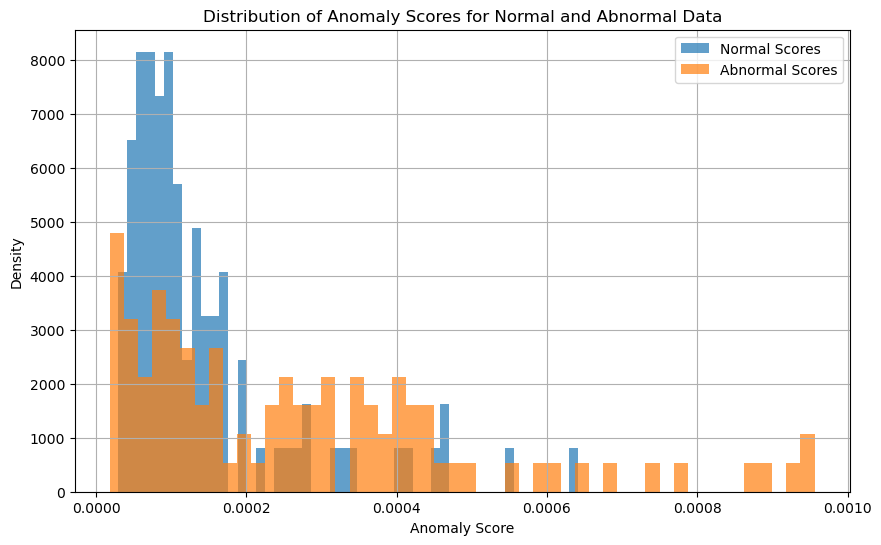

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import clear_output
import math
import warnings

# 忽略K-means在未來版本中的警告
warnings.filterwarnings("ignore")


class PositionalEncoding(nn.Module):
    """位置編碼，讓Transformer能夠感知序列中的位置資訊"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class MEMTO(nn.Module):
    """
    MEMTO 模型，嚴格按照論文架構實現
    包含：Transformer Encoder, Gated Memory Module, Weak Decoder
    """
    def __init__(self, input_dim, seq_len, latent_dim, n_heads, n_layers, num_memory_items, temperature=0.1, dropout=0.1):
        super(MEMTO, self).__init__()
        
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.num_memory_items = num_memory_items
        self.temperature = temperature

        # 1. Encoder
        # 將輸入維度投影到潛在維度
        self.input_projection = nn.Linear(input_dim, latent_dim)
        self.pos_encoder = PositionalEncoding(latent_dim, dropout, max_len=seq_len)
        encoder_layers = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads, dim_feedforward=latent_dim*4, dropout=dropout, batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=n_layers)

        # 2. Gated Memory Module
        # 論文提到記憶體項目 m 被訓練來包含正常的原型模式 [cite: 128]
        # 初始時隨機初始化，後續透過K-means進行賦值
        self.memory_items = nn.Parameter(torch.randn(num_memory_items, latent_dim), requires_grad=True)
        
        # Gated Memory Update Stage 的線性投影層 [cite: 138]
        self.U_psi = nn.Linear(latent_dim, latent_dim, bias=False)
        self.W_psi = nn.Linear(latent_dim, latent_dim, bias=False)

        # 3. Weak Decoder
        # 論文強調使用一個弱解碼器，以避免其能力過強而導致過度泛化 [cite: 120, 121, 122]
        # 輸入維度為 2 * latent_dim，因為它結合了原始查詢和檢索到的記憶體項目 [cite: 115]
        self.decoder = nn.Sequential(
            nn.Linear(2 * latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, input_dim)
        )
        
    def forward(self, x, is_train=True):
        # x shape: (batch_size, seq_len, input_dim)
        
        # --- Encoder ---
        # 投影到 latent_dim
        x_proj = self.input_projection(x)
        
        # TransformerEncoder期望的輸入 shape: (seq_len, batch_size, latent_dim)
        x_proj = x_proj.permute(1, 0, 2)
        x_pos = self.pos_encoder(x_proj)
        
        # queries shape: (seq_len, batch_size, latent_dim)
        queries = self.transformer_encoder(x_pos)
        
        # 轉換回 (batch_size, seq_len, latent_dim) 以便於後續操作
        queries = queries.permute(1, 0, 2)

        # --- Gated Memory Module ---
        
        # --- Query Update Stage (訓練和預測時都會執行) ---
        # 根據論文公式(4)計算 memory-conditioned query-attention [cite: 142]
        # q_s_m_similarity shape: (batch_size, seq_len, num_memory_items)
        q_s_m_similarity = F.normalize(queries, p=2, dim=-1) @ F.normalize(self.memory_items, p=2, dim=-1).T
        w = F.softmax(q_s_m_similarity / self.temperature, dim=-1) # w_t,i^s
        
        # 根據論文公式(5)計算 retrieved memory items [cite: 145]
        # retrieved_memory shape: (batch_size, seq_len, latent_dim)
        retrieved_memory = w @ self.memory_items # ~q_t^s
        
        # 根據論文，將原始查詢和檢索到的記憶體項目串接 [cite: 98, 147]
        updated_queries = torch.cat([queries, retrieved_memory], dim=-1) # q^_t^s
        
        # --- Decoder ---
        # 使用弱解碼器進行重建
        reconstructed_x = self.decoder(updated_queries)
        
        # --- Gated Memory Update Stage (僅在訓練時執行) [cite: 139] ---
        if is_train:
            # 根據論文公式(1)計算 query-conditioned memory attention [cite: 129]
            # v_i,t^s, 注意softmax的維度是在seq_len上
            m_q_s_similarity = q_s_m_similarity.permute(0, 2, 1) # (batch_size, num_memory_items, seq_len)
            v = F.softmax(m_q_s_similarity / self.temperature, dim=-1)
            
            # 計算查詢的加權和
            weighted_queries = v @ queries # shape: (batch_size, num_memory_items, latent_dim)
            
            # 對batch維度取平均，因為記憶體更新是全局的
            weighted_queries_mean = weighted_queries.mean(dim=0) # shape: (num_memory_items, latent_dim)
            
            # 根據論文公式(2)計算更新門 psi [cite: 135]
            psi = torch.sigmoid(self.U_psi(self.memory_items) + self.W_psi(weighted_queries_mean))
            
            # 根據論文公式(3)更新記憶體項目 [cite: 135]
            self.memory_items.data = (1 - psi) * self.memory_items.data + psi * weighted_queries_mean

        return reconstructed_x, queries, w


class MEMTOAgent:
    def __init__(self, input_dim, seq_len, latent_dim=64, n_heads=4, n_layers=3, 
                 num_memory_items=10, temperature=0.1, lambda_entr=0.01, lr=5e-5,
                 phase1_epochs=10, device=None):
        """
        Agent for training and predicting with MEMTO model.
        內建好模型的設定.
        """
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # 模型超參數
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.num_memory_items = num_memory_items
        
        # 訓練超參數
        self.lr = lr
        self.lambda_entr = lambda_entr # 論文公式(8)中的 lambda [cite: 163]
        self.phase1_epochs = phase1_epochs
        
        # 實例化模型
        self.model = MEMTO(
            input_dim=input_dim,
            seq_len=seq_len,
            latent_dim=latent_dim,
            n_heads=n_heads,
            n_layers=n_layers,
            num_memory_items=num_memory_items,
            temperature=temperature
        ).to(self.device)

        # 優化器與損失函數
        # 論文使用 Adam optimizer [cite: 436]
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # 論文使用 L2 loss 作為重建損失 [cite: 153]
        self.reconstruction_loss_fn = nn.MSELoss()

    def _entropy_loss(self, w):
        """計算論文公式(7)中的熵損失 L_entr [cite: 158]"""
        # w shape: (batch_size, seq_len, num_memory_items)
        # 加上一個極小值避免 log(0)
        entropy = -w * torch.log(w + 1e-9)
        return torch.mean(entropy)

    def _anomaly_score(self, x, x_hat, queries):
        """
        計算 bi-dimensional deviation-based anomaly score.
        結合 Input Space Deviation (ISD) 和 Latent Space Deviation (LSD). [cite: 192]
        """
        # 1. 計算 Input Space Deviation (ISD) [cite: 195, 197]
        # x, x_hat shape: (batch_size, seq_len, input_dim)
        isd = torch.mean((x - x_hat)**2, dim=-1) # shape: (batch_size, seq_len)

        # 2. 計算 Latent Space Deviation (LSD) [cite: 193, 196]
        # queries shape: (batch_size, seq_len, latent_dim)
        # memory_items shape: (num_memory_items, latent_dim)
        dist_matrix = torch.cdist(queries.reshape(-1, self.latent_dim), self.model.memory_items)
        min_dist, _ = torch.min(dist_matrix, dim=1)
        lsd = min_dist.reshape(x.shape[0], self.seq_len) # shape: (batch_size, seq_len)

        # 3. 結合 ISD 和 LSD 計算異常分數 [cite: 201]
        # 論文公式 (11)
        lsd_softmax = F.softmax(lsd, dim=1)
        anomaly_scores_per_timestamp = lsd_softmax * isd # element-wise multiplication
        
        # 對每個樣本的時間步取最大值作為該樣本的最終異常分數
        final_scores, _ = torch.max(anomaly_scores_per_timestamp, dim=1)
        
        return final_scores

    def _k_means_init(self, dataloader):
        """
        執行 Two-phase training paradigm 的第一階段結束後的 K-means 初始化. [cite: 182]
        """
        print("--- Starting K-means Initialization for Memory Items ---")
        self.model.eval()
        all_queries = []
        
        # 論文中提到使用10%的訓練數據進行K-means [cite: 183]
        # 這裡為了簡化，我們使用 dataloader 的一部分
        num_batches_for_kmeans = max(1, len(dataloader) // 10)
        
        with torch.no_grad():
            for i, (batch_x,) in enumerate(dataloader):
                if i >= num_batches_for_kmeans:
                    break
                batch_x = batch_x.to(self.device)
                
                # 只需通過 Encoder 獲取 queries
                x_proj = self.model.input_projection(batch_x).permute(1, 0, 2)
                x_pos = self.model.pos_encoder(x_proj)
                queries = self.model.transformer_encoder(x_pos).permute(1, 0, 2)
                
                all_queries.append(queries.reshape(-1, self.latent_dim).cpu().numpy())
        
        all_queries = np.concatenate(all_queries, axis=0)
        
        # 執行 K-means
        kmeans = KMeans(n_clusters=self.num_memory_items, random_state=42, n_init=10)
        kmeans.fit(all_queries)
        
        # 將聚類中心作為 memory items 的初始值 [cite: 184]
        centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(self.device)
        self.model.memory_items.data = centroids
        print("--- K-means Initialization Finished ---")


    def train(self, dataloader, epochs):
        # 隨機挑選一個樣本用於視覺化
        sample_x, = next(iter(dataloader))
        sample_x = sample_x[:1].to(self.device)

        losses = []

        # --- Phase 1: Pre-training Encoder ---
        # 論文提到第一階段是訓練模型以用於後續的K-means [cite: 183]
        # 這裡我們只訓練重建損失，不更新memory
        print(f"--- Starting Phase 1: Pre-training for {self.phase1_epochs} epochs ---")
        for epoch in range(self.phase1_epochs):
            self.model.train()
            for (batch_x,) in dataloader:
                batch_x = batch_x.to(self.device)
                self.optimizer.zero_grad()
                
                # is_train=False to prevent memory update
                reconstructed_x, _, _ = self.model(batch_x, is_train=False) 
                
                loss = self.reconstruction_loss_fn(reconstructed_x, batch_x)
                loss.backward()
                self.optimizer.step()
            print(f"Phase 1, Epoch {epoch+1}/{self.phase1_epochs}, Loss: {loss.item():.6f}")

        # --- K-means Initialization ---
        self._k_means_init(dataloader)

        # --- Phase 2: Main Training ---
        print(f"--- Starting Phase 2: Main training for {epochs} epochs ---")
        for epoch in range(epochs):
            self.model.train()
            epoch_losses = []
            
            for (batch_x,) in dataloader:
                batch_x = batch_x.to(self.device)
                self.optimizer.zero_grad()
                
                # 執行完整的 forward pass，包含 Gated Memory Update
                reconstructed_x, _, w = self.model(batch_x, is_train=True)
                
                # 計算損失函數 [cite: 160]
                rec_loss = self.reconstruction_loss_fn(reconstructed_x, batch_x)
                entr_loss = self._entropy_loss(w)
                total_loss = rec_loss + self.lambda_entr * entr_loss
                
                total_loss.backward()
                self.optimizer.step()
                epoch_losses.append(total_loss.item())

            avg_loss = np.mean(epoch_losses)
            losses.append(avg_loss)
            
            # 每10個epoch畫一次圖
            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                fig, axes = plt.subplots(1, 2, figsize=(15, 5))
                
                # 繪製 Learning Curve
                axes[0].plot(range(1, len(losses) + 1), losses, marker='o')
                axes[0].set_title(f'Epoch-Loss Learning Curve (Epoch {epoch+1})')
                axes[0].set_xlabel('Epoch')
                axes[0].set_ylabel('Total Loss')
                axes[0].grid(True)
                
                # 繪製單一樣本的重建結果
                self.model.eval()
                with torch.no_grad():
                    recon_sample, _, _ = self.model(sample_x, is_train=False)
                
                axes[1].plot(sample_x[0, :, 0].cpu().numpy(), label='Original Signal 1', alpha=0.7)
                axes[1].plot(recon_sample[0, :, 0].cpu().numpy(), label='Reconstructed Signal 1', linestyle='--')
                axes[1].plot(sample_x[0, :, 1].cpu().numpy(), label='Original Signal 2', alpha=0.7)
                axes[1].plot(recon_sample[0, :, 1].cpu().numpy(), label='Reconstructed Signal 2', linestyle='--')
                axes[1].set_title(f'Sample Reconstruction at Epoch {epoch+1}')
                axes[1].set_xlabel('Time Step')
                axes[1].set_ylabel('Value')
                axes[1].legend()
                axes[1].grid(True)
                
                plt.tight_layout()
                plt.show()

        print("Training finished.")

    def predict(self, dataloader):
        self.model.eval()
        all_scores = []
        with torch.no_grad():
            for (batch_x,) in dataloader:
                batch_x = batch_x.to(self.device)
                
                reconstructed_x, queries, _ = self.model(batch_x, is_train=False)
                
                scores = self._anomaly_score(batch_x, reconstructed_x, queries)
                all_scores.append(scores.cpu().numpy())
        
        return np.concatenate(all_scores)

# ===================================================================
#                      主程式 (Main Program)
# ===================================================================

# (10) 寫主程式，會建構這個agent，然後以以下程式碼作為一個訓練和測試並且畫出正常異常的分數分佈圖
import numpy as np
def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T


if __name__ == '__main__':
    # --- 1. 資料準備 ---
    N_train = 500
    N_test = 100
    
    # 訓練資料只包含正常樣本，符合非監督式設定 [cite: 24]
    train_data = np.array([normal_data_generator() for _ in range(N_train)])
    
    # 測試資料包含正常與異常樣本
    test_normal_data = np.array([normal_data_generator() for _ in range(N_test)])
    test_abnormal_data = np.array([abnormal_data_generator() for _ in range(N_test)])
    
    # 標準化 (非常重要)
    mean, std = train_data.mean(axis=(0,1)), train_data.std(axis=(0,1))
    train_data = (train_data - mean) / std
    test_normal_data = (test_normal_data - mean) / std
    test_abnormal_data = (test_abnormal_data - mean) / std
    
    # 轉換為 PyTorch Tensors 和 DataLoaders
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    test_normal_tensor = torch.tensor(test_normal_data, dtype=torch.float32)
    test_abnormal_tensor = torch.tensor(test_abnormal_data, dtype=torch.float32)

    train_dataset = TensorDataset(train_tensor)
    test_normal_dataset = TensorDataset(test_normal_tensor)
    test_abnormal_dataset = TensorDataset(test_abnormal_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_normal_loader = DataLoader(test_normal_dataset, batch_size=32, shuffle=False)
    test_abnormal_loader = DataLoader(test_abnormal_dataset, batch_size=32, shuffle=False)

    SEQ_LEN = train_data.shape[1]
    INPUT_DIM = train_data.shape[2]

    # --- 2. 建構 Agent 並進行訓練 ---
    memto_agent = MEMTOAgent(
        input_dim=INPUT_DIM, 
        seq_len=SEQ_LEN,
        latent_dim=32,
        n_heads=2,
        n_layers=2,
        num_memory_items=10, # 論文實驗顯示10個記憶體項目是個高效的選擇 [cite: 317, 319]
        phase1_epochs=100,     # 縮短第一階段以加快範例執行
    )
    
    memto_agent.train(train_loader, epochs=200) # 論文通常訓練更多epoch，這裡為了演示而減少
    
    # --- 3. 進行預測 ---
    print("\nPredicting on normal test data...")
    normal_scores = memto_agent.predict(test_normal_loader)
    
    print("Predicting on abnormal test data...")
    abnormal_scores = memto_agent.predict(test_abnormal_loader)
    
    # --- 4. 畫出正常/異常分數的分佈圖 ---
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Scores', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Scores', density=True)
    plt.title('Distribution of Anomaly Scores for Normal and Abnormal Data')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()